---
# Modified VGG Backbone Model on KITTI
---

In [12]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from pathlib import Path
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import datetime
from IPython.display import clear_output, display
from base64 import b64encode
from IPython.display import HTML

In [13]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths
train_data_dir = "/DML/Datasets/KITTI_ROAD/training/image_2/"
train_gt_dir = "/DML/Datasets/KITTI_ROAD/training/gt_image_2/"
test_data_dir = "/DML/Datasets/KITTI_ROAD/testing/"

In [14]:
# # Number of training examples
# TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
# VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
# TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)

# Initialize constants
IMG_SIZE = 512
N_CHANNELS = 3
N_CLASSES = 1
BATCH_SIZE = 16
SEED = 42

# Set random seed for reproducibility
torch.manual_seed(SEED)

In [15]:
class KittiRoadDataset(Dataset):
    def __init__(self, sample_images_dir, sample_masks_dir, img_format="*.png", mask_format="*.png", transform=None, label_filter="road"):
        # Load and sort images and masks
        self.img_files = sorted(list(Path(sample_images_dir).glob(img_format)))
        self.mask_files = sorted(list(Path(sample_masks_dir).glob(mask_format)))

        # Filter masks for the class "label_filter"
        if label_filter:
            self.mask_files = [file for file in self.mask_files if label_filter in os.path.basename(file)]
        
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.img_files[idx]).convert("RGB")
        mask = Image.open(self.mask_files[idx]).convert("RGB")  # Color mask

        # Resize image and mask before converting the mask to binary
        image = image.resize((IMG_SIZE, IMG_SIZE))
        mask = mask.resize((IMG_SIZE, IMG_SIZE))

        # Convert the mask to a binary class label (1=road, 0=not road)
        mask = self.binary_encode_mask(np.array(mask))

        # Apply transformations to image and mask
        if self.transform:
            image = self.transform(image)
            # mask = self.transform(mask)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Convert to a 1xHxW tensor


        # # One-hot encoding for the mask
        # mask = self.one_hot_encode(np.array(mask))  # One-hot encode the mask

        return image, mask

    def binary_encode_mask(self, mask_array):
        # Define the color labels (KITTI road: magenta, non-road: red, background: black)
        road_label = np.array([255, 0, 255])  # Magenta for road
        non_road_label = np.array([255, 0, 0])  # Red for non-road

        # Create binary mask: 1 for road, 0 for non-road
        binary_mask = np.all(mask_array == road_label, axis=-1).astype(np.uint8)

        return binary_mask
    

In [16]:
# Define image transformations
# transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor()])

# Create datasets
train_dataset = KittiRoadDataset(train_data_dir, train_gt_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Image Shape: torch.Size([16, 3, 512, 512])
Mask Shape: torch.Size([16, 1, 512, 512])


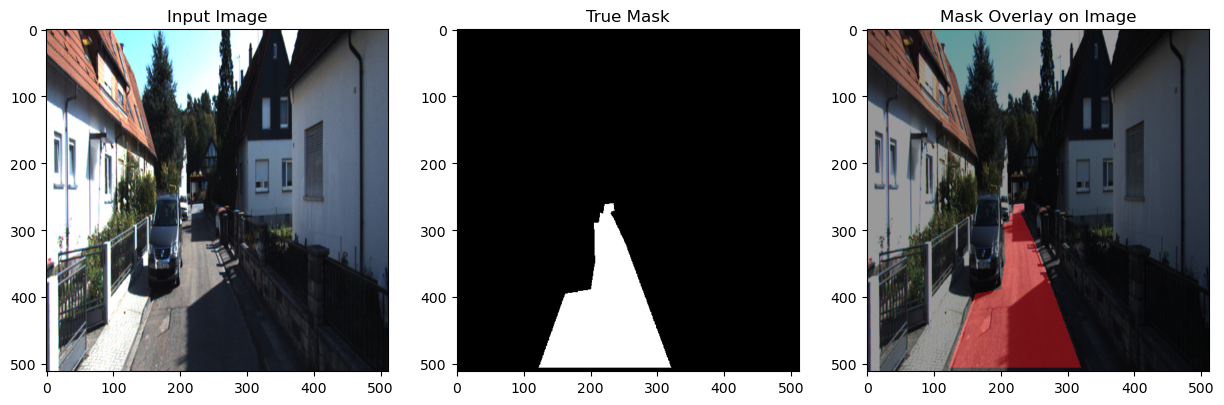

In [17]:
# Fix for OpenMP conflict
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.set_num_threads(1)

# Function to overlay mask on the input image
def overlay_mask_on_image(image, mask, alpha=0.4):
    # Move the image and mask to the CPU and detach from the computation graph
    image = image.cpu().detach()
    mask = mask.cpu().detach()

    # Ensure mask is 2D for overlay
    if mask.dim() == 3 and mask.size(0) == 1:
        mask = mask.squeeze(0)

    # Normalize image (if needed) to be in the range [0, 1]
    image = image.permute(1, 2, 0)   # [C, H, W] -> [H, W, C]
    image = (image - image.min()) / (image.max() - image.min())
    # image = image - image.min()
    # image = image / image.max()

    # Convert the mask to RGB for overlaying
    mask_rgb = torch.stack([mask, torch.zeros_like(mask), torch.zeros_like(mask)], dim=-1)
    # mask_rgb = torch.stack([mask, mask, mask], dim=-1)

    # Overlay: blend the mask and image using alpha
    overlay = (1 - alpha) * image + alpha * mask_rgb

    return overlay

# Sample visualization function
def display_sample(image, mask):
    # Move the image and mask to the CPU and detach from the computation graph
    image = image.cpu().detach()
    mask = mask.cpu().detach()

    # Squeeze the mask if it has an extra dimension
    if mask.dim() == 3 and mask.size(0) == 1:
        mask = mask.squeeze(0)

    # Create figure with three subplots: image, mask, overlay
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    # Plot the input image
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title('Input Image')

    # Plot the mask (ensure it's 2D for grayscale)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('True Mask')

    # Create and plot the overlay image
    overlay = overlay_mask_on_image(image, mask)
    ax[2].imshow(overlay)
    ax[2].set_title('Mask Overlay on Image')

    plt.show()

# Display a sample from the dataset
for images, masks in train_loader:
    print(f"Image Shape: {images.shape}") 
    print(f"Mask Shape: {masks.shape}")
    display_sample(images[0], masks[0])
    break

In [18]:
# Define FCN network using VGG-16 as backbone
class FCN_VGG(nn.Module):
    def __init__(self, num_classes):
        super(FCN_VGG, self).__init__()
        # vgg = models.vgg16(pretrained=True)
        vgg = models.vgg16()
        vgg.load_state_dict(torch.load("/DML/vgg16-397923af.pth"))
        self.features = vgg.features
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=8, stride=8)
        
        # Final segmentation layer
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.features(x)
        
        # Upsampling path
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        
        return torch.sigmoid(self.classifier(x))

Epoch 1/5, Loss: 0.5045554763392398


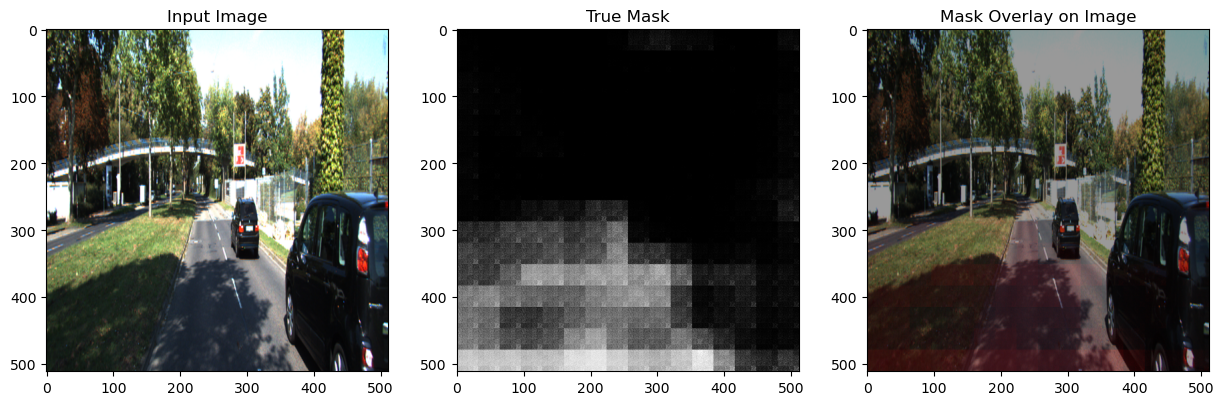

  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
# Initialize model, optimizer, and loss function
model = FCN_VGG(num_classes=N_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

# Training loop
EPOCHS = 5
model.train()

for epoch in range(EPOCHS):
    running_loss = 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    clear_output(wait=True)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}")
    
    # Display predictions
    with torch.no_grad():
        for images, masks in train_loader:
            images = images.to(device)
            outputs = model(images)
            display_sample(images[0].cpu(), outputs[0].cpu())
            break

In [20]:
# Inference and saving predictions
def save_predictions(dataset, model, save_dir):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)
    for idx, (image, mask) in enumerate(dataset):
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_mask = model(image).cpu().squeeze()
        
        pred_mask = (pred_mask > 0.5).float()
        save_sample(image.cpu().squeeze(), pred_mask, idx, save_dir)

def save_sample(image, mask, idx, save_dir):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title('Input Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Predicted Mask')
    plt.savefig(os.path.join(save_dir, f"prediction_{idx}.png"))
    plt.close()

# Run inference and save predictions
save_predictions(train_dataset, model, save_dir="outputs")

KeyboardInterrupt: 